In [37]:
import numpy as np
import cv2
import operator #to bring some necessary operators mostly object comparison and logical mathematical operations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#first function for preprocessing the image
#skip_dilate for performing dilate in the image because want to extract the grid
def preprocessing_image(img,skip_dilate=False):
    temp=cv2.GaussianBlur(img.copy(),(9,9),0)
    temp=cv2.adaptiveThreshold(temp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    #putting bitwise for invertion of the image
    #not takes background and merge them in our case only one image
    #so inverting
    proc=cv2.bitwise_not(temp,temp)
    if not skip_dilate:
        kernal = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        temp=cv2.dilate(temp,kernal)
    return temp


def find_corners_of_largest_polygon(img):
    contours,h=cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours=sorted(contours,key=cv2.contourArea,reverse=True)
    largest_one=contours[0]
    
    #bottem right largest x+y
    #top_left smallest x+y
    #bottem left x-y smallest
    #top left x-y largest
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in largest_one]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in largest_one]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in largest_one]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in largest_one]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [largest_one[top_left][0], largest_one[top_right][0], largest_one[bottom_right][0], largest_one[bottom_left][0]]


def distance_between_two_cords(p1, p2):
    """Returns the scalar distance_between_two_cords between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))



def croping_and_warping(img,crop_rect):
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
    source = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    # Get the longest side in the rectangle
    side = max([
        distance_between_two_cords(bottom_right, top_right),
        distance_between_two_cords(top_left, bottom_left),
        distance_between_two_cords(bottom_right, bottom_left),
        distance_between_two_cords(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    prespective = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(source, prespective)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

def infer_grid(img):
    square=[]
    side=img.shape[:1] #getting the first one
    side=side[0]/9  #means how much one box is taking in 9x9 boxes grid
    
    for i in range(9):
        for j in range(9):
            point1=(j*side,i*side)
            point2=((j+1)*side,(i+1)*side)
            square.append((point1,point2))
    return square


def extract_digit(img, rect, size):
    """Extracts a digit (if one exists) from a Sudoku square."""

    full_rectangle = cut_from_rect(img, rect)  # Get the digit box from the whole square

    # Use fill feature finding to get the largest feature in middle of the box
    # Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
    h, w = full_rectangle.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(full_rectangle, [margin, margin], [w - margin, h - margin])
    full_rectangle = cut_from_rect(full_rectangle, bbox)

    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(full_rectangle) > 0:
        return scale_and_centre(full_rectangle, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

    
    

def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))    

    
def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    """
    Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
    connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
    """
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]

    max_area = 0
    seed_point = (None, None)

    if scan_tl is None:
        scan_tl = [0, 0]

    if scan_br is None:
        scan_br = [width, height]

    # Loop through the image
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
        # Only operate on light or white squares
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

    # Highlight the main feature
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)

            # Find the bounding parameters
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point    


def get_digits(img, square, size):
    """Extracts digits from their cells and builds an array"""
    digits = []
    img = preprocessing_image(img.copy(), skip_dilate=True)
    for square in square:
        digits.append(extract_digit(img, square, size))
    return digits


def plot_many_images(images, titles, rows=1, columns=2):
    """Plots each image in a given list as a grid structure. using Matplotlib."""
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()


def show_image(img):
    """Shows an image until any key is pressed"""
#    print(type(img))
#    print(img.shape)
#    cv2.imshow('image', img)  # Display the image
#    cv2.imwrite('images/gau_sudoku3.jpg', img)
#    cv2.waitKey(0)  # Wait for any key to be pressed (with the image window active)
#    cv2.destroyAllWindows()  # Close all windows
    return img


def show_digits(digits, colour=255):
    """Shows list of 81 extracted digits in a grid format"""
    rows = []
    with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
    for i in range(9):
        row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
        rows.append(row)
    img = show_image(np.concatenate(rows))
    return img
 

def convert_when_colour(colour, img):
    """Dynamically converts an image to colour if the input colour is a tuple and the image is grayscale."""
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img


def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()

    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_image(img)
    return img


def parse_grid(path):
    original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    processed = preprocessing_image(original)
    
#    cv2.namedWindow('processed',cv2.WINDOW_AUTOSIZE)
#    processed_img = cv2.resize(processed, (500, 500))          # Resize image
#    cv2.imshow('processed', processed_img)
    
    corners = find_corners_of_largest_polygon(processed)
    cropped = croping_and_warping(original, corners)
    
#    cv2.namedWindow('cropped',cv2.WINDOW_AUTOSIZE)
#    cropped_img = cv2.resize(cropped, (500, 500))              # Resize image
#    cv2.imshow('cropped', cropped_img)
    
    squares = infer_grid(cropped)
    #print(squares)
    digits = get_digits(cropped, squares, 28)
#    print(digits)
    final_image = show_digits(digits)
    return final_image

def extract_sudoku(image_path):
    final_image = parse_grid(image_path)
    return final_image

if __name__ == '__main__':
    image=extract_sudoku('sudoku.png')

In [38]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#for making the version as 1 and using methods of version 1

predicted:  6


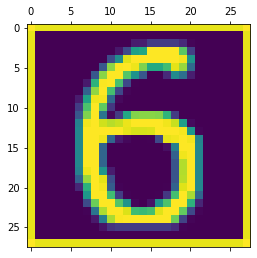

In [62]:
newModel=tf.keras.models.load_model('fiorst.h5')
sudoku_img=extract_sudoku('sudoku.png')
from skimage.transform import resize
sudoku=resize(sudoku_img,(252,252))
k=sudoku[5*28:(5+1)*28,8*28:(8+1)*28]
plt.matshow(k)
print("predicted: ",np.argmax(newModel.predict(k.reshape((-1,28,28,1)))).astype(int))

In [63]:
def get_grid(image_path):
    sudoku=extract_sudoku(image_path)
    from skimage.transform import resize
    sudoku = resize(sudoku, (252,252))
    grid = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            image = sudoku[i*28:(i+1)*28,j*28:(j+1)*28]
            if image.sum() >105:    
                grid[i][j] = np.argmax(newModel.predict(image.reshape((1,28,28,1)))).astype(int)
            else:
                grid[i][j] = 0
    grid =  grid.astype(int)
    return grid
sudoku_grid=get_grid('sudoku.png')
sudoku_grid

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

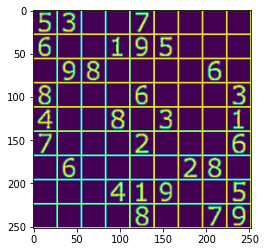

In [97]:
sudoku=extract_sudoku('sudoku.png')
from skimage.transform import resize
sudoku = resize(sudoku, (252,252))
plt.imshow(sudoku)
plt.imsave("onePic2.jpg", sudoku)

In [98]:
def solve(bo):
    find=find_empty(bo)
    if not find:
        return True
    else:
        row,col=find
    for i in range(1,10):
        if valid(bo,i,(row,col)):
            bo[row][col] = i

            if solve(bo):
                return True
            bo[row][col]=0
    return False


def valid(bo,num,pos):
    #checking row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] !=i:
            return False
    #checking  col
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] !=i:
            return False

    #check box
    box_x=pos[1]//3
    box_y=pos[0]//3

    for i in range(box_y*3 , box_y*3+3):
        for j in range(box_x*3,box_x*3+3):
            if bo[i][j]==num and (i,j)!=pos:
                return False
    return True

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i,j)
    return None


In [99]:
k=sudoku_grid.tolist()
solve(k)
k

[[5, 3, 4, 6, 7, 8, 9, 1, 2],
 [6, 7, 2, 1, 9, 5, 3, 4, 8],
 [1, 9, 8, 3, 4, 2, 5, 6, 7],
 [8, 5, 9, 7, 6, 1, 4, 2, 3],
 [4, 2, 6, 8, 5, 3, 7, 9, 1],
 [7, 1, 3, 9, 2, 4, 8, 5, 6],
 [9, 6, 1, 5, 3, 7, 2, 8, 4],
 [2, 8, 7, 4, 1, 9, 6, 3, 5],
 [3, 4, 5, 2, 8, 6, 1, 7, 9]]

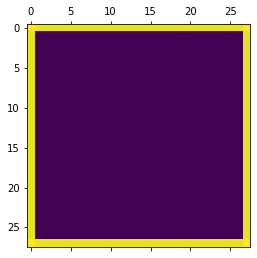

In [100]:
#saving image of all the digits in a dictionary
dict_map={0:sudoku[0*28:(0+1)*28,2*28:(2+1)*28],
          1:sudoku[1*28:(1+1)*28,3*28:(3+1)*28],
          2:sudoku[6*28:(6+1)*28,6*28:(6+1)*28],
          3:sudoku[0*28:(0+1)*28,1*28:(1+1)*28],
          4:sudoku[4*28:(4+1)*28,0*28:(0+1)*28],
          5:sudoku[0*28:(0+1)*28,0*28:(0+1)*28],
          6:sudoku[1*28:(1+1)*28,0*28:(0+1)*28],
          7:sudoku[0*28:(0+1)*28,4*28:(4+1)*28],
          8:sudoku[3*28:(3+1)*28,0*28:(0+1)*28],
          9:sudoku[2*28:(2+1)*28,1*28:(1+1)*28]}
plt.matshow(dict_map[0])

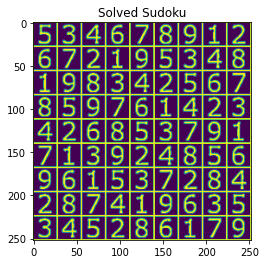

In [101]:
import matplotlib.pyplot as plt
new_sudoku=sudoku[:]
for i in range(9):
    for j in range(9):
        new_sudoku[i*28:(i+1)*28,j*28:(j+1)*28]=dict_map[k[i][j]]#Here sudoku_grid is sudoku_solution grid

#Solved Sudoku
plt.imshow(new_sudoku)
plt.title('Solved Sudoku')
plt.show()
plt.imsave("onePic.jpg", new_sudoku)